<a href="https://colab.research.google.com/github/WarpHero/AI_Training/blob/main/Non_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tensorflow Tutorial
https://www.tensorflow.org/tutorials/keras/regression?hl=ko

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


# 자동차 연비 예측하기

## 데이터 구하기
- 먼저 데이터셋을 다운로드 하기

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

30286/30286 [==============================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [ ]:
len(dataset)

398

비정상 데이터 제거 dropna

In [7]:
dataset=dataset.dropna()

In [8]:
len(dataset)

392

Origin data 제거
- "Origin" 열은 수치형이 아니고 범주형이므로 원-핫 인코딩(one-hot encoding)으로 변환하겠습니다:

In [9]:
dataset.pop('Origin')

0      1
1      1
2      1
3      1
4      1
      ..
393    1
394    2
395    1
396    1
397    1
Name: Origin, Length: 392, dtype: int64

In [10]:
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
0,18.0,8,307.0,130.0,3504.0,12.0,70
1,15.0,8,350.0,165.0,3693.0,11.5,70
2,18.0,8,318.0,150.0,3436.0,11.0,70
3,16.0,8,304.0,150.0,3433.0,12.0,70
4,17.0,8,302.0,140.0,3449.0,10.5,70
...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82
394,44.0,4,97.0,52.0,2130.0,24.6,82
395,32.0,4,135.0,84.0,2295.0,11.6,82
396,28.0,4,120.0,79.0,2625.0,18.6,82


## 데이터셋을 훈련 세트와 테스트 세트로 분할
- 이제 데이터를 훈련 세트와 테스트 세트로 분할
- 테스트 세트는 모델을 최종적으로 평가할 때 사용

In [11]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [12]:
len(train_dataset), len(test_dataset)

(314, 78)

## 정규화 하기
- dataset의 숫자들의 편차가 크기 때문에 어느정도 크기를 통일시켜 줄 필요가 있음

- 특성의 스케일과 범위가 다르면 정규화(normalization)하는 것이 권장됩니다. 특성을 정규화하지 않아도 모델이 수렴할 수 있지만, 훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어집니다.

노트: 의도적으로 훈련 세트만 사용하여 통계치를 생성했습니다. 이 통계는 테스트 세트를 정규화할 때에도 사용됩니다. 이는 테스트 세트를 모델이 훈련에 사용했던 것과 동일한 분포로 투영하기 위해서입니다.


-> 통계적인 값이 필요함(avg, std 같은 것들)

-> describe()를 이용해 구해줌

In [13]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


### 특성과 레이블 분리하기
- 특성에서 타깃 값 또는 "레이블"을 분리합니다. 이 레이블을 예측하기 위해 모델을 훈련시킬 것입니다.

ex) mpg는 정규화를 하지 말아야 하므로 제외시켜줌 

In [14]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### 데이터 정규화

In [15]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [16]:
normed_train_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971


## 모델

### 모델만들기
- 모델을 구성해 보죠. 여기에서는 두 개의 완전 연결(densely connected) 은닉층으로 Sequential 모델을 만들겠습니다. 출력 층은 하나의 연속적인 값을 반환합니다. 나중에 두 번째 모델을 만들기 쉽도록 build_model 함수로 모델 구성 단계를 감싸겠습니다.

In [17]:
normed_train_data.shape

(314, 6)

data feature의 size가 중요하기 때문에
Input으로 넣어준다

In [18]:
inputs=keras.Input(shape=(normed_train_data.shape[1],))
h=layers.Dense(64)(inputs)
# gradient vanishing: hidden layer의 depth가 깊어질수록 학습이 잘 안되는 현상이 발생할 수 있음
# ReLU : input이 positive면 gradient=1이므로 gradient vanishing 방지 가능
h=layers.Activation('relu')(h)
outputs=layers.Dense(1)(h) 

In [20]:
model=keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(0.001))

### 모델 확인

- summary 메서드 사용해 모델에 대한 간단한 정보를 출력한다.

In [21]:
model.summary() #input -> 중간레이어 -> output(결과값 1개)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 64)                448       
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


- visualize 함수 plot_model()
   레이어 별로 input output 나옴



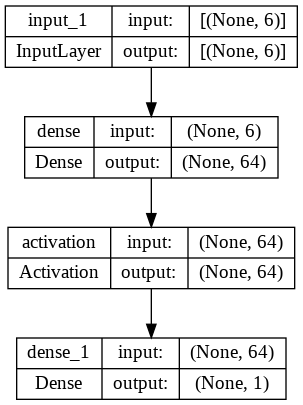

In [22]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

모델을 한 번 실행해 본다.
train_set에서 10 sample을 하나의 배치로 만들어 model.predict()를 이용해 호출해본다.

In [23]:
normed_train_data[:10].shape

(10, 6)

학습이 전혀 안 된 모델이므로 기대값과 다른 값이 나오는게 정상이다

In [24]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 375ms/step


array([[ 0.17343663],
       [ 0.06495132],
       [-0.33456752],
       [ 0.2860868 ],
       [ 0.1322043 ],
       [ 0.09557676],
       [ 0.15003294],
       [-0.00862686],
       [-0.0726111 ],
       [-0.14398897]], dtype=float32)

### 모델훈련
- 이 모델을 1000번의 에포크(epoch)동안 훈련함. 훈련 정확도와 검증 정확도는 history 객체에 기록 됨.

- fit(input_data, output_data, epochs,validation_split)
- validation set : 과적합을 방지하기 위해 따로 분류해 놓은 값 (학습에 쓰이지 않는 값)

In [27]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2,)

Epoch 1/1000
8/8 [==============================] - 0s 10ms/step - loss: 5.9320 - val_loss: 8.7813
Epoch 2/1000
8/8 [==============================] - 0s 8ms/step - loss: 5.9524 - val_loss: 8.7825
Epoch 3/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.9461 - val_loss: 8.7778
Epoch 4/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.9455 - val_loss: 8.8161
Epoch 5/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.9330 - val_loss: 8.7957
Epoch 6/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.9308 - val_loss: 8.7781
Epoch 7/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.9812 - val_loss: 8.7652
Epoch 8/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.9060 - val_loss: 8.8108
Epoch 9/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.9375 - val_loss: 8.8267
Epoch 10/1000
8/8 [==============================] - 0s 6ms/step - loss: 5.9772 - val_loss: 8.7901
Epoch 11/1000
8/8 

In [28]:

# EarlyStopping() : val loss가 어느 값 이후로 줄어들지 않으면 학습을 종료시키는 함수
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop])

In [29]:
loss=model.evaluate(normed_test_data, test_labels, verbose=2) #평가 함수 evaluate()
print('테스트 세트의 평균 절대 오차: {:5.2f} MPG'.format(loss))

3/3 - 0s - loss: 6.6021 - 24ms/epoch - 8ms/step
테스트 세트의 평균 절대 오차:  6.60 MPG


## 예측
- 셈플을 사용해 MPG 값 예측

3/3 [==============================] - 0s 4ms/step


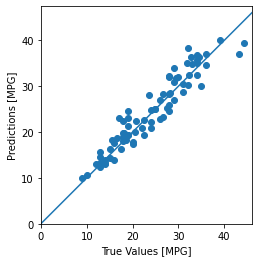

In [30]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

조금이지만 직선에 가까운 형태로 모델이 학습 됨